# Imports

In [ ]:
%run mask_to_submission # This generates dummy_submission.csv which is needed to import submission_to_mask w/o errors

In [68]:
from mask_to_submission import *
from submission_to_mask import *
from helpers import *

import numpy as np

import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

from IPython.display import Image
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory data analysis

## Training images and ground truth
#### Just a peek at what the data looks like

In [ ]:
rcParams['figure.figsize'] = 11 ,8

img_train_1 = mpimg.imread('training/images/satImage_001.png')
img_gt_1 = mpimg.imread('training/groundtruth/satImage_001.png')

fig, ax = plt.subplots(1,2)

ax[0].imshow(img_train_1)
ax[0].title.set_text('Train image 1')
ax[1].imshow(img_gt_1, cmap="gray")
ax[1].title.set_text('Groundtruth 1')

# Data augmentation

## Split image into patches

In [ ]:
sub_image_1 = img_train_1[200:216, 200:216]
sub_image_2 = img_train_1[240:256, 260:276]
fig, ax = plt.subplots(1,2)

ax[0].imshow(sub_image_1)
ax[0].title.set_text('Train subimage 1, road')
ax[1].imshow(sub_image_2)
ax[1].title.set_text('Train subimage 2, not road')

#### Basically we cannot train on independent 16x16 images, we need to train on the whole image/a bigger patch.

#### As we only have 100 train images, we can split those images into patches of a smaller size. Size is restricted to a multiple of 16 (for the submission) that must divide 400 (image length and width)

In [ ]:
#See function split_into_patches(img, patchsize) in helpers.py

#### Demonstration

In [ ]:
patchsize = 80
si = split_into_patches(img_train_1, patchsize)

fig, ax = plt.subplots(5,5) # Works for patchsize = 80
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(si[5*i + j])

#### Same can be applied to ground truth

In [ ]:
patchsize = 80
si = split_into_patches(img_gt_1, patchsize)

fig, ax = plt.subplots(5,5) # Works for patchsize = 80
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(si[5*i + j], cmap="gray")

### Random patches

In [98]:
def split_into_random_n_patches(img, n, patchsize, tlcs=[]):
    assert len(tlcs) == 0 or len(tlcs) == n, "Invalid top-left corners list. Must be either empty or have length n"
    tlcs_empty = len(tlcs) == 0
    
    sub_images = []
    width_valid_tlc = img.shape[0] - patchsize
    height_valid_tlc = img.shape[1] - patchsize
    
    for i in range(n):
        if tlcs_empty: # This allows us to use this argument to fetch corresponding ground truth
            tlc = np.random.randint(0, width_valid_tlc), np.random.randint(0, height_valid_tlc)
            tlcs.append(tlc)
        sub_images.append(img[tlcs[i][0]:tlcs[i][0]+patchsize,tlcs[i][1]:tlcs[i][1]+patchsize])
            
    return np.array(sub_images), tlcs

#### Demonstration

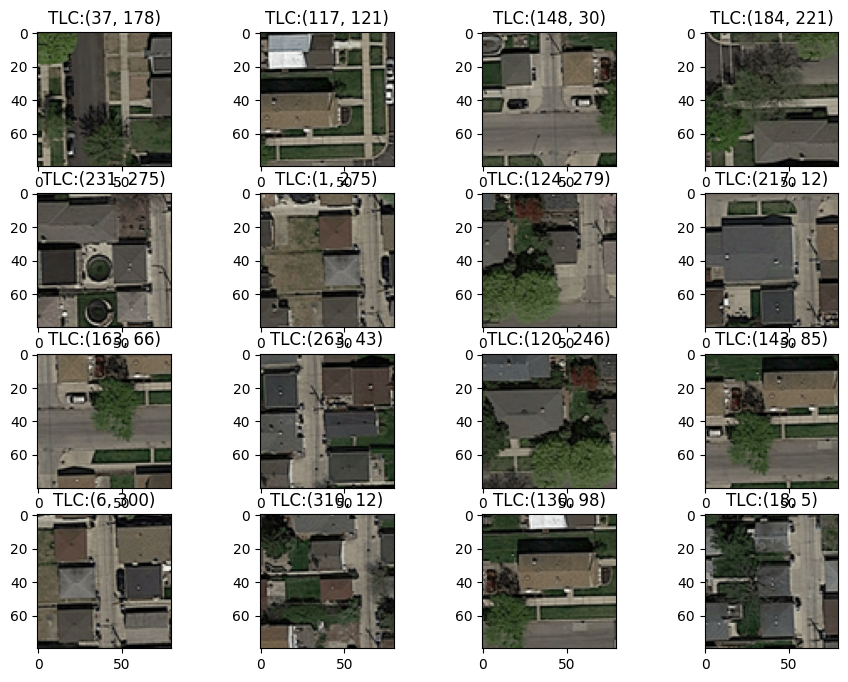

In [99]:
si_rand, tlcs_rand = split_into_random_n_patches(img_train_1, 4*4, patchsize) # Notice tlcs is *not* specified

fig, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        ax[i,j].title.set_text("TLC:" + str(tlcs_rand[4*i + j]))
        ax[i,j].imshow(si_rand[4*i + j])

#### Ground truth can be computed using optional argument

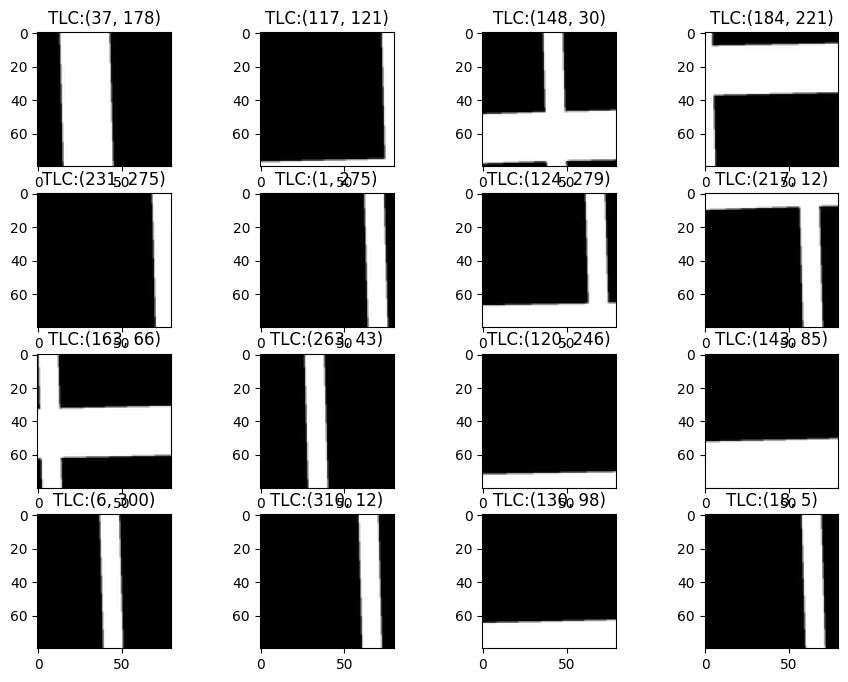

In [100]:
si_rand, tlcs_rand = split_into_random_n_patches(img_gt_1, 4*4, patchsize, tlcs_rand) # Notice tlcs is specified

fig, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        ax[i,j].title.set_text("TLC:" + str(tlcs_rand[4*i + j]))
        ax[i,j].imshow(si_rand[4*i + j], cmap = "gray")

## Rotate images